In [57]:
import numpy as np
import GPy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import safeopt

In [58]:
np.random.seed(42)

In [59]:
# Define the global reward function
def f(x1, x2, x3):
    y = np.sin(x1**3) + np.cos(x2**2) - np.sin(x3)
    return y

In [60]:
# Define the function to run experiments
def run_experiments(a1, a2, a3, iterations):
    rewards = np.array([])
    actions_1 = np.array([])
    actions_2 = np.array([])
    actions_3 = np.array([])

    for i in range(iterations):
        x1 = a1.optimize()
        x2 = a2.optimize()
        x3 = a3.optimize()

        actions_1 = np.append(actions_1, x1)
        actions_2 = np.append(actions_2, x2)
        actions_3 = np.append(actions_3, x3)

        y = f(x1, x2, x3)
        rewards = np.append(rewards, y)

        # 50% of the time maximize, 50% of the time minimize (by changing the sign of the reward)
        if i < iterations // 2:
            a1.update(x1, y)
            a2.update(x2, y)
            a3.update(x3, y)
        else:
            a1.update(x1, -y)
            a2.update(x2, -y)
            a3.update(x3, -y)

    return actions_1, actions_2, actions_3, rewards

In [61]:
def compute_gradient(model, X):
    dmu_dX, _ = model.predictive_gradients(X)
    return dmu_dX

In [62]:
N=5
D=3

In [63]:

def generate_actions(N):
    x1 = np.random.uniform(-1.5, 1.5, N)
    x2 = np.random.uniform(-1.5, 1.5, N)
    x3 = np.random.uniform(-1.5, 1.5, N)
    R = f(x1, x2, x3)
    return x1, x2, x3, R

In [64]:
X1, X2,X3, R_original = generate_actions(N)
X = np.vstack((X1, X2,X3)).T

Z = np.random.uniform(-1.5, 1.5, (N, D))


#perfrom experiments
R = f(X1, X2,X3)
R_Z_init = f(Z[:,0], Z[:,1], Z[:,2])

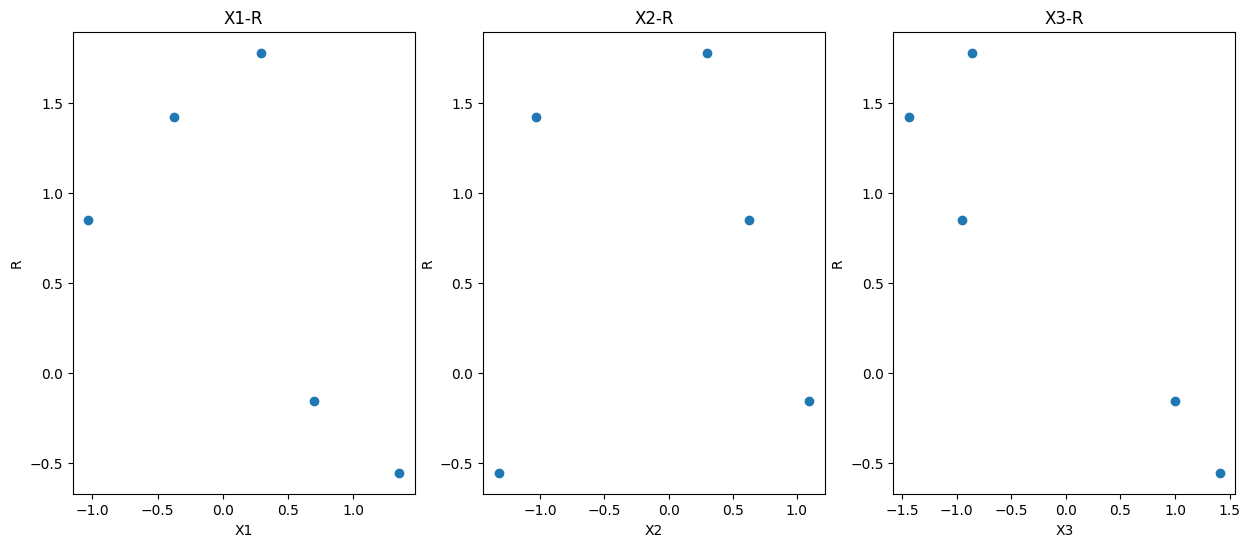

In [65]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.scatter(X1, R, label='X1')
plt.ylabel('R')
plt.xlabel('X1')
plt.title('X1-R')
plt.subplot(1, 3, 2)
plt.scatter(X2, R, label='X2')
plt.ylabel('R')
plt.xlabel('X2')
plt.title('X2-R')
plt.subplot(1, 3, 3)
plt.scatter(X3, R, label='X3')
plt.ylabel('R')
plt.xlabel('X3')
plt.title('X3-R')
plt.show()


In [66]:
model_X = GPy.models.GPRegression(X, R_original[:, None], GPy.kern.RBF(input_dim=D))
model_Z_init = GPy.models.GPRegression(Z, R_Z_init[:, None], GPy.kern.RBF(input_dim=D))


In [67]:
def create_U_matrice_columnwise(model_X,model_Z,X,Z):
    N = X.shape[0]
    D = X.shape[1]

    U_x = np.zeros((N, D))
    U_z = np.zeros((N, D))

    grad_R_X_norm_column = []
    grad_R_Z_norm_column = []

    for d in range(D):
        grad_R_X = compute_gradient(model_X, X)
        grad_R_Z = compute_gradient(model_Z, Z)

        grad_R_X = grad_R_X.reshape(N, D)
        grad_R_Z = grad_R_Z.reshape(N, D)

        grad_R_Z_norm_column.append(np.linalg.norm(grad_R_Z[:, d]))
        grad_R_X_norm_column.append(np.linalg.norm(grad_R_X[:, d]))

        U_z[:, d] = grad_R_Z[:, d] / grad_R_Z_norm_column[d]
        U_x[:, d] = grad_R_X[:, d] / grad_R_X_norm_column[d]

    dot_product_matrix = np.dot(U_z.T, U_x)
    print('dot_product_matrix\n', dot_product_matrix)
    print("Trace:", np.sum(np.diag(dot_product_matrix))/D)

    return U_x, U_z

In [68]:
def plot_3d_vector_column_wise(U_x, U_z):
    N = U_x.shape[0]
    D = U_x.shape[1]

    print("U_x\n", U_x)
    print("U_z\n", U_z)
    # Create a single figure and axis for all column vectors
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('U_x and U_z vectors')

    colors = ['r', 'g', 'b']
    for i in range(D):
        # Extract columns from U_x and U_z
        v1 = U_x[:, i]
        v2 = U_z[:, i]

        # Origin point for vectors
        origin = [0, 0, 0]
        # Plot each vector
        ax.quiver(*origin, *v1, color=colors[i], length=1.0, label=f'U_x_{i}: {v1}')
        ax.quiver(*origin, *v2, color=colors[i], linestyle='dashed', length=1.0, label=f'U_z_{i}: {v2}')

    # Set plot limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # Show legend
    ax.legend()

    # Display the plot
    plt.show()


In [69]:
# np.random.seed(42)

In [70]:
U_x, U_z = create_U_matrice_columnwise(model_X,model_Z_init,X,Z)

dot_product_matrix
 [[-0.15185868  0.32622779 -0.3292855 ]
 [ 0.55485492  0.2917478   0.08984123]
 [ 0.49696138 -0.29015293  0.28426902]]
Trace: 0.14138604581158762


In [71]:
# plot_3d_vector_column_wise(U_x, U_z)

In [72]:
def column_wise(Z_flat, X, D, N, sigma2, f):
    Z = Z_flat.reshape(N, D)

    # Define model_Z with R_z as observations
    model_Z = GPy.models.GPRegression(Z, R.reshape(-1,1), GPy.kern.RBF(D))
    model_all = GPy.models.GPRegression(Z, X,  GPy.kern.RBF(D))
    mu_all, _ = model_all.predict_noiseless(Z)

    loss = 0.0
    grad_R_Z_norm_column = []
    grad_R_X_norm_column = []

    # Initialize matrices for U_z and U_x
    U_z = np.zeros((N, D))
    U_x = np.zeros((N, D))

    for d in range(D):
        X_d = np.zeros_like(X)
        X_d[:, d] = X[:, d]
        
        model_d = GPy.models.GPRegression(Z, X_d,GPy.kern.RBF(D))
        mu_d, _ = model_d.predict_noiseless(Z)

        diff1 = np.linalg.norm(X_d - mu_d)**2
        diff2 = np.linalg.norm(mu_d - mu_all[:, [d]])**2
        
        loss += diff1 + 0.2 * diff2

        # Gradient-based alignment term
        grad_R_Z = compute_gradient(model_Z, Z).reshape(N, D)
        grad_R_X = compute_gradient(model_X, X).reshape(N, D)

        grad_R_Z_norm_column.append(np.linalg.norm(grad_R_Z[:, d]))
        grad_R_X_norm_column.append(np.linalg.norm(grad_R_X[:, d]))

        U_z[:, d] = grad_R_Z[:, d] / grad_R_Z_norm_column[d]
        U_x[:, d] = grad_R_X[:, d] / grad_R_X_norm_column[d]


    # Compute the dot product matrix after the loop
    dot_product_matrix = np.dot(U_z.T, U_x)
    diag_penalty = np.linalg.norm((1 - np.diag(dot_product_matrix)))/D

    # mu_z_est , _ = model_Z.predict_noiseless(Z)
    # mu_x_est , _ = model_X.predict_noiseless(X)

    # diff3 = np.linalg.norm(mu_x_est - mu_z_est)**2
    
    total_loss = loss + diag_penalty 


    return total_loss

In [73]:
# max_iter = 5
result = minimize(column_wise, Z.flatten(), args=(X, D, N, 1e-2, f), method='L-BFGS-B')

In [74]:
Z_opt = result.x.reshape(N, D)

In [75]:
R_Z_opt = f(Z_opt[:, 0], Z_opt[:, 1], Z_opt[:, 2])

In [76]:
model_Z_opt = GPy.models.GPRegression(Z_opt, R_Z_opt[:, None], GPy.kern.RBF(input_dim=D))

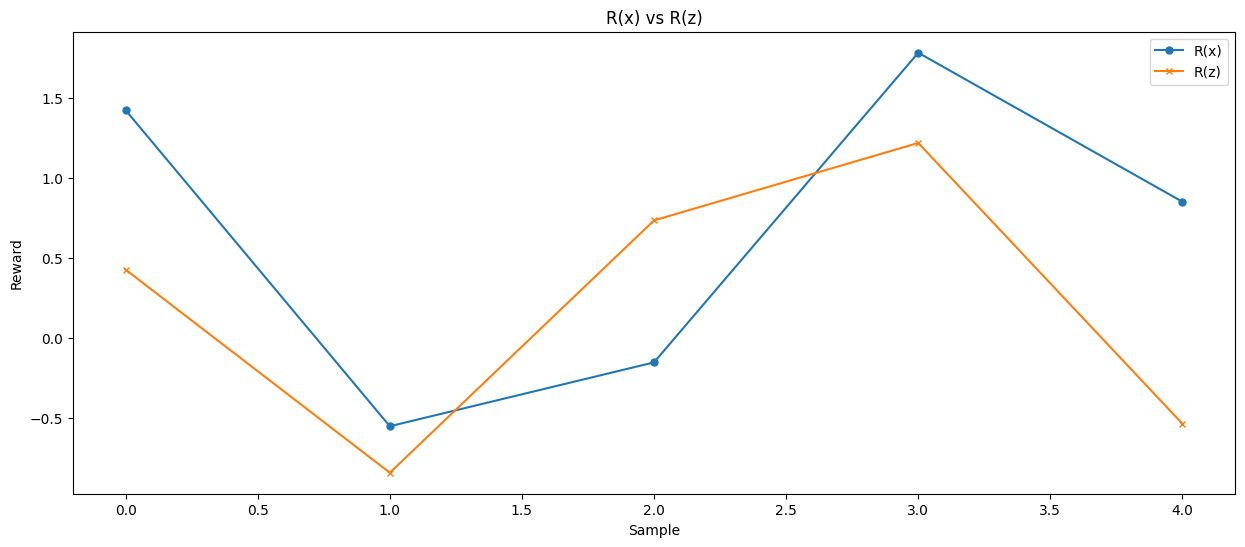

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(R, label='R(x)', marker='o', markersize=5)
plt.plot(R_Z_opt, label='R(z)', marker='x', markersize=5)
plt.title('R(x) vs R(z)')
plt.xlabel('Sample')
plt.ylabel('Reward')
plt.legend()
plt.show()

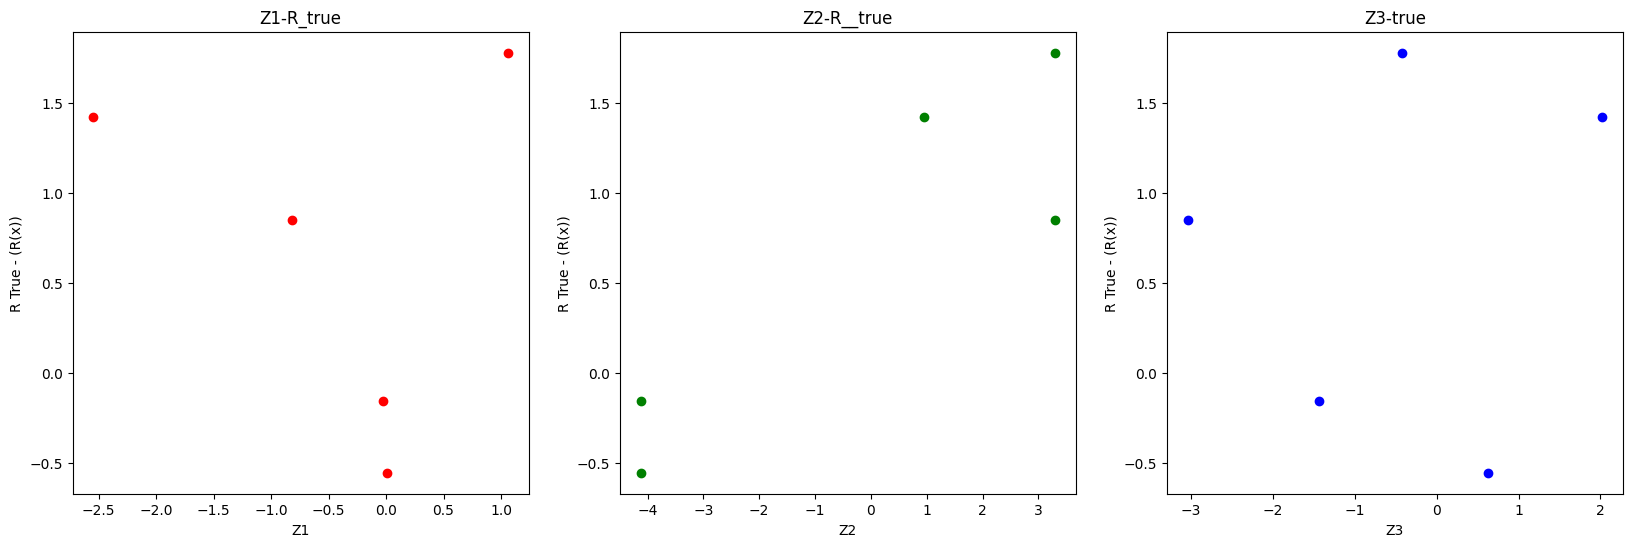

In [78]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.scatter(Z_opt[:, 0], R, c='r')
plt.title('Z1-R_true')
plt.ylabel('R True - (R(x))')
plt.xlabel('Z1')

plt.subplot(1, 3, 2)  
plt.scatter(Z_opt[:, 1], R, c='g')
plt.title('Z2-R__true')
plt.ylabel('R True - (R(x))')
plt.xlabel('Z2')


plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.scatter(Z_opt[:, 2], R, c='b')
plt.title('Z3-true')
plt.ylabel('R True - (R(x))')
plt.xlabel('Z3')

# Display the figure with all subplots
plt.show()

In [79]:
U_X_opt, U_Z_opt = create_U_matrice_columnwise(model_X, model_Z_opt, X, Z_opt)

dot_product_matrix
 [[ 0.61197    -0.60355266 -0.08036758]
 [-0.04828585  0.96784931  0.79509885]
 [ 0.13337053  0.03235147  0.56136066]]
Trace: 0.7137266552335056


Plotting used only for 3 samples

In [80]:
# plot_3d_vector_column_wise(U_X_opt, U_Z_opt)

In [81]:
class Agent:
    def __init__(self, id, bounds, safe_point):
        self.bounds = [bounds]
        self.id = id
        self.global_rewards = np.array([])
        self.max_belief = np.array([[]])

        self.z0 = np.asarray([[safe_point]])
        self.y0 = np.asarray([[0.5]])

        self.kernel = GPy.kern.RBF(1)
        self.gp = GPy.models.GPRegression(self.z0, self.y0, self.kernel, noise_var=0.05**2)
        self.parameter_set = safeopt.linearly_spaced_combinations(self.bounds, 100)
        self.opt = safeopt.SafeOpt(self.gp, self.parameter_set, -np.inf, beta=2, threshold=0.2)

    def optimize(self):
        z_next = self.opt.optimize()
        return z_next
    
    def update(self, z_next, y_meas):
        self.max_belief = np.append(self.max_belief, self.opt.get_maximum()[1])
        self.opt.add_new_data_point(z_next, y_meas)

    def plot_opt(self):
        self.opt.plot(1000)

In [82]:
# Initialize agents
agent1 = Agent(1, (-1.5, 1.5), 0.1)
agent2 = Agent(2, (-1.5, 1.5), 0.2)
agent3 = Agent(3, (-1.5, 1.5), 0.3)


In [83]:
model_Z_X_0 = GPy.models.GPRegression(Z_opt[:,0].reshape(-1,1), X[:,0].reshape(-1,1), GPy.kern.RBF(1))
model_Z_X_1 = GPy.models.GPRegression(Z_opt[:,1].reshape(-1,1), X[:,1].reshape(-1,1), GPy.kern.RBF(1))
model_Z_X_2 = GPy.models.GPRegression(Z_opt[:,2].reshape(-1,1), X[:,2].reshape(-1,1), GPy.kern.RBF(1))

print(model_Z_X_0.X)

model_X_Z_0 = GPy.models.GPRegression(X[:,0].reshape(-1,1), Z_opt[:,0].reshape(-1,1), GPy.kern.RBF(1))
model_X_Z_1 = GPy.models.GPRegression(X[:,1].reshape(-1,1), Z_opt[:,1].reshape(-1,1), GPy.kern.RBF(1))
model_X_Z_2 = GPy.models.GPRegression(X[:,2].reshape(-1,1), Z_opt[:,2].reshape(-1,1), GPy.kern.RBF(1))



[[-2.54548757]
 [ 0.00761638]
 [-0.0282609 ]
 [ 1.06047873]
 [-0.81881508]]


In [84]:
def run_experiments(agent1,agent2,agent3,N):

    rewards = np.array([])
    actions_1 = np.array([])
    actions_2 = np.array([])
    actions_3 = np.array([])

    for i in range(N):

        z1_next = agent1.optimize()
        z2_next = agent2.optimize()
        z3_next = agent3.optimize()
        print(z1_next, z2_next, z3_next)

        x1_next = model_Z_X_0.predict_noiseless(z1_next.reshape(-1,1))[0]
        x2_next = model_Z_X_1.predict_noiseless(z2_next.reshape(-1,1))[0]
        x3_next = model_Z_X_2.predict_noiseless(z3_next.reshape(-1,1))[0]  

        print(x1_next, x2_next, x3_next)

        x1_next = np.asarray([x1_next]).flatten()
        x2_next = np.asarray([x2_next]).flatten()
        x3_next = np.asarray([x3_next]).flatten()
        
        print(x1_next, x2_next, x3_next)

        actions_1 = np.append(actions_1, x1_next)
        actions_2 = np.append(actions_2, x2_next)
        actions_3 = np.append(actions_3, x3_next)


        y = f(x1_next, x2_next, x3_next)

        agent1.update(z1_next,y)
        agent2.update(z2_next,y)
        agent3.update(z3_next,y)

    return actions_1, actions_2, actions_3

[-1.5] [-1.5] [-1.5]
[[-0.41099324]] [[-0.02859318]] [[0.19980351]]
[-0.41099324] [-0.02859318] [0.19980351]
[1.5] [1.5] [1.5]
[[0.21985298]] [[-0.38684988]] [[-0.17639534]]
[0.21985298] [-0.38684988] [-0.17639534]
[-0.71212121] [-0.68181818] [-0.65151515]
[[-0.04473388]] [[-0.13913102]] [[0.08618862]]
[-0.04473388] [-0.13913102] [0.08618862]
[0.89393939] [0.92424242] [0.95454545]
[[0.46550973]] [[-0.50656184]] [[0.20925796]]
[0.46550973] [-0.50656184] [0.20925796]
[-1.13636364] [-1.13636364] [-1.10606061]
[[-0.3053783]] [[-0.06057973]] [[0.15071973]]
[-0.3053783] [-0.06057973] [0.15071973]
[1.13636364] [1.5] [1.5]
[[0.36978308]] [[-0.38684988]] [[-0.17639534]]
[0.36978308] [-0.38684988] [-0.17639534]
[1.5] [1.16666667] [1.1969697]
[[0.21985298]] [[-0.48014769]] [[0.06103613]]
[0.21985298] [-0.48014769] [0.06103613]
[0.98484848] [1.5] [1.5]
[[0.43162602]] [[-0.38684988]] [[-0.17639534]]
[0.43162602] [-0.38684988] [-0.17639534]
[1.5] [1.31818182] [1.5]
[[0.21985298]] [[-0.4453728]] [[-0

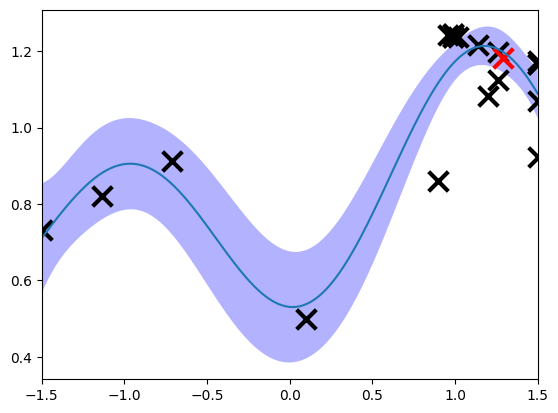

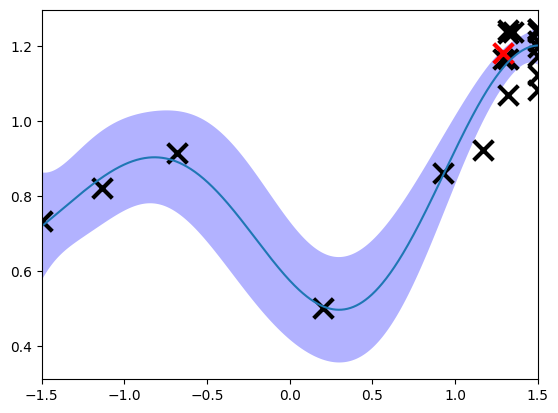

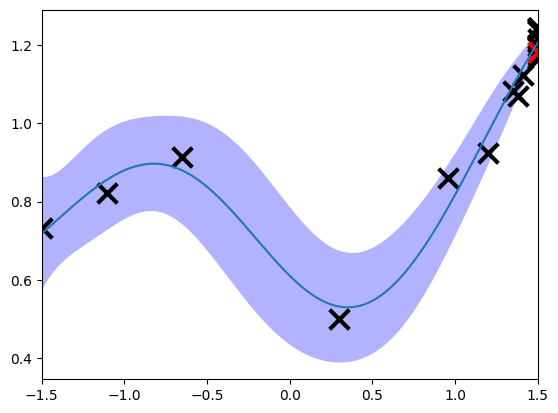

In [85]:
actions_1, actions_2, actions_3 = run_experiments(agent1, agent2, agent3, 20)

agent1.plot_opt()
agent2.plot_opt()
agent3.plot_opt()

[ 0.25260089 -0.19010209  0.35318257 -0.11427558 -0.10354499]


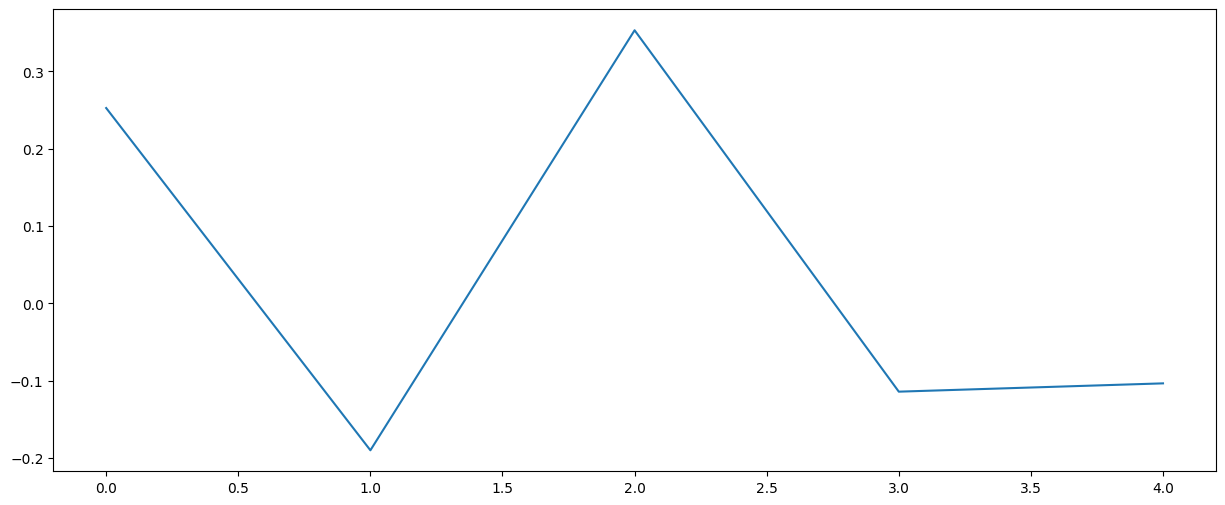

In [86]:
ZR = GPy.models.GPRegression(Z_opt[:,2].reshape(-1,1), R[:, None], GPy.kern.RBF(1))
dmu_z_dX =  compute_gradient(ZR, Z_opt[:,2].reshape(-1,1))
print(dmu_z_dX.flatten())
model_grad_R_X = GPy.models.GPRegression(dmu_z_dX.reshape(-1,1), X[:, 2].reshape(-1,1), GPy.kern.RBF(1))
plt.figure(figsize=(15, 6))
plt.plot(dmu_z_dX.flatten(), label='X3')

[[1.06047873]
 [1.78147948]]


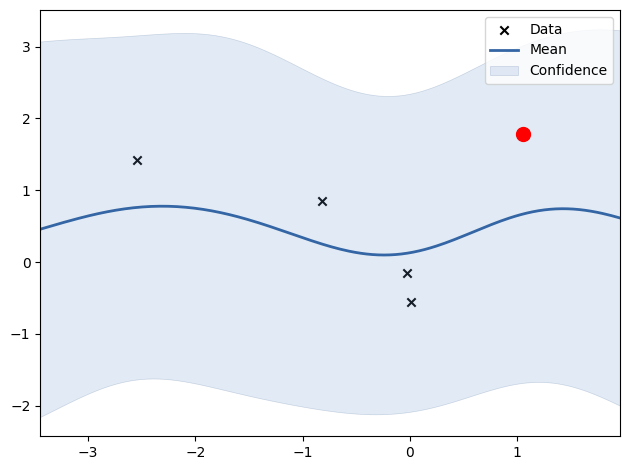

In [87]:
model_1_Z_opt_R = GPy.models.GPRegression(Z_opt[:,0].reshape(-1,1), R[:, None], GPy.kern.RBF(1))

max_y1 = max(model_1_Z_opt_R.Y).astype(float)
max_x1 = model_1_Z_opt_R.X[np.where(model_1_Z_opt_R.Y == max_y1)]
max_coords1 = np.array([max_x1, max_y1])
print(max_coords1)
model_1_Z_opt_R.plot()
plt.scatter(max_coords1[0], max_coords1[1], color='red', s=100)

{'dataplot': [<matplotlib.collections.PathCollection at 0x78ce38d4d5b0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x78ce38d4da00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x78ce38d35c10>]}

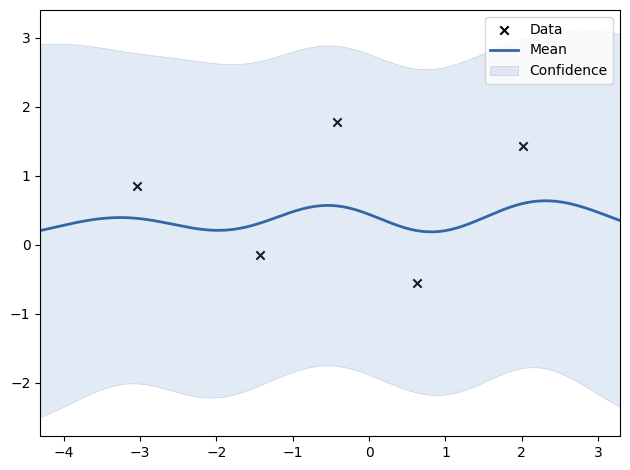

In [88]:
model_3_Z_opt_R = GPy.models.GPRegression(Z_opt[:,2].reshape(-1,1), R[:, None], GPy.kern.RBF(1))
model_3_Z_opt_R.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x78ce38d4eb70>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x78ce38e39610>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x78ce38e39850>]}

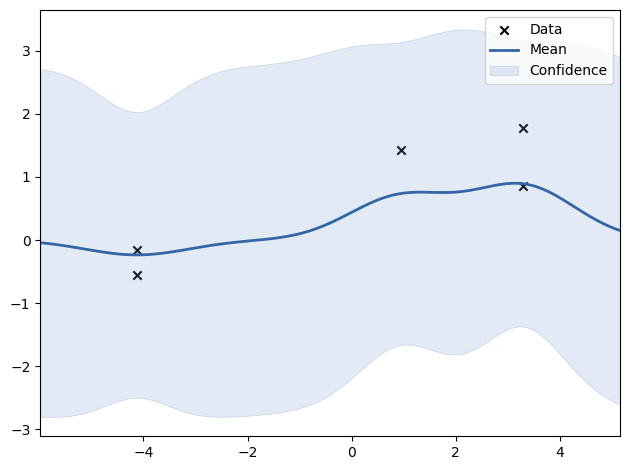

In [89]:
model_2_Z_opt_R = GPy.models.GPRegression(Z_opt[:,1].reshape(-1,1), R[:, None], GPy.kern.RBF(1))
model_2_Z_opt_R.plot()

Sample: [ 0.11575829 -0.01031424 -0.05750746 -0.2335774   0.4662388 ]
Direction: [ 0.00141214 -0.22842665 -0.25816976  0.3799056   0.85839349]
Directional Derivative: 0.3288451961291922
Directional Vector: [ 0.00046437 -0.07511701 -0.08489789  0.12493013  0.28227858]
Sample: [ 0.35339869  0.00381155 -0.0538295  -0.19464362 -0.27501652]
Direction: [ 0.68703788 -0.19516232 -0.22503011 -0.45197732 -0.48473556]
Directional Derivative: 0.47545246128239926
Directional Vector: [ 0.32665385 -0.0927904  -0.10699112 -0.21489373 -0.23046872]
Sample: [ 0.13930299 -0.02473359 -0.19369083 -0.13537118 -0.03110376]
Direction: [-4.80901329e-05 -6.61199463e-01 -7.47302196e-01  2.67502121e-02
  6.03251380e-02]
Directional Derivative: 0.1555951704522421
Directional Vector: [-7.48259243e-06 -1.02879443e-01 -1.16276613e-01  4.16220381e-03
  9.38630013e-03]


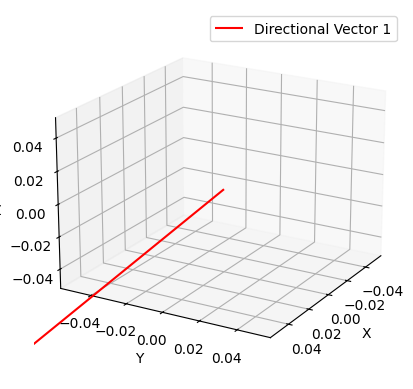

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b']
for d in range(3):
    gradient = compute_gradient(model_X, X)
    sample = gradient[:, d].flatten()  # Flatten to make it a 1D array
    print("Sample:", sample)
    
    direction = U_Z_opt[:, d]
    print("Direction:", direction)

    directional_derivative = np.dot(sample, direction)
    print("Directional Derivative:", directional_derivative)

    directional_vector = directional_derivative * direction
    print("Directional Vector:", directional_vector)

    
    origin = np.zeros(3)

    if d ==0:
        # Plot the directional vector
        ax.quiver(origin[0], origin[1], origin[2], directional_vector[0], directional_vector[1], directional_vector[2], 
                length=1, normalize=True, label=f'Directional Vector {d+1}', color=colors[d])

# Set plot labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
#change the view angle
ax.view_init(elev=20, azim=30)

plt.show()

{'dataplot': [<matplotlib.collections.PathCollection at 0x78ce38fb2600>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x78ce38fb2c60>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x78ce38d52fc0>]}

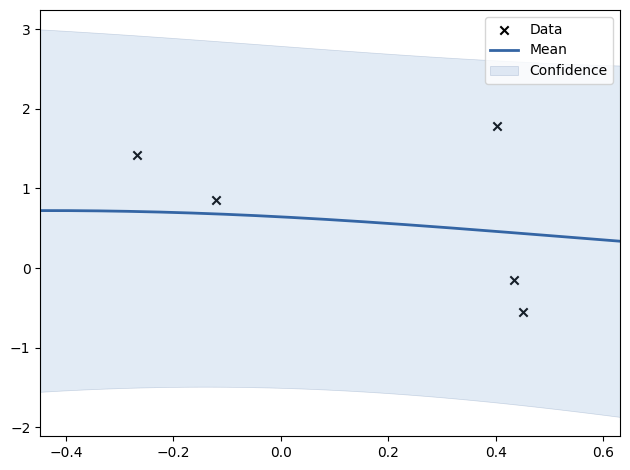

In [91]:
model_actions_Z = GPy.models.GPRegression(Z_opt[:,0].reshape(-1,1), X[:,0].reshape(-1,1), GPy.kern.RBF(1))
mu_actions_Z, _ = model_actions_Z.predict_noiseless(Z_opt[:,0].reshape(-1,1))


mode_R_Z_actions = GPy.models.GPRegression(mu_actions_Z, R.reshape(-1,1), GPy.kern.RBF(1))
mode_R_Z_actions.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x78ce38fbe420>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x78ce38ff4bc0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x78ce38ff4dd0>]}

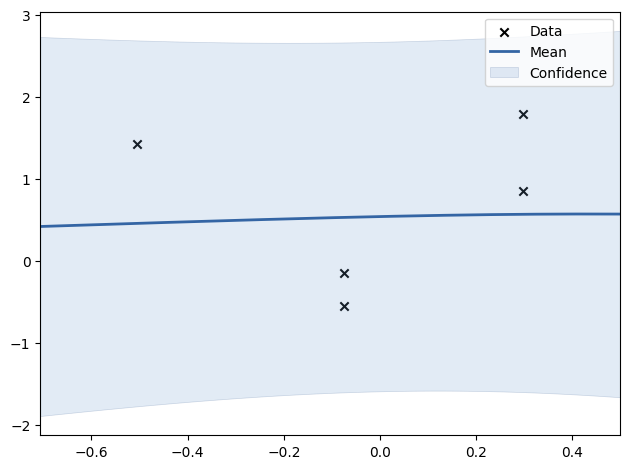

In [92]:
model_actions_Z = GPy.models.GPRegression(Z_opt[:,1].reshape(-1,1), X[:,1].reshape(-1,1), GPy.kern.RBF(1))
mu_actions_Z, _ = model_actions_Z.predict_noiseless(Z_opt[:,1].reshape(-1,1))

mode_R_Z_actions = GPy.models.GPRegression(mu_actions_Z, R.reshape(-1,1), GPy.kern.RBF(1))
mode_R_Z_actions.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x78ce39034ef0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x78ce38c650a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x78ce38c54cb0>]}

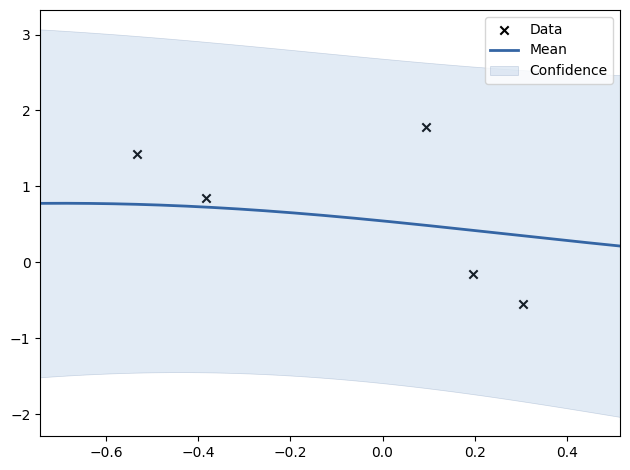

In [93]:
model_actions_Z = GPy.models.GPRegression(Z_opt[:,2].reshape(-1,1), X[:,2].reshape(-1,1), GPy.kern.RBF(1))
mu_actions_Z, _ = model_actions_Z.predict_noiseless(Z_opt[:,2].reshape(-1,1))

mode_R_Z_actions = GPy.models.GPRegression(mu_actions_Z, R.reshape(-1,1), GPy.kern.RBF(1))
mode_R_Z_actions.plot()

In [94]:
# np.random.seed(42)  